<a href="https://colab.research.google.com/github/t-chapman/telco_churn/blob/main/Telco_Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



1.   Define the problem, and propose a solution
2.   Construct the dataset



> *   Collect raw data
*   Identify feature and label sources
*   Select a sampling strategy
*   Split the data





3.   Transform data


> *   Explore and clean the data
*   Feature engineering




4.   Train a model
5.   Use the model to make predicions








Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing 
from sklearn.model_selection import (GridSearchCV, train_test_split)
from sklearn.tree import (DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (RandomForestClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, roc_curve, auc, roc_auc_score,
                             confusion_matrix, classification_report)
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.under_sampling import RandomUnderSampler

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Import data

In [2]:
df=pd.read_csv("/content/drive/MyDrive/o2_demo_telco_churn.csv")

Inspect the data

In [3]:
df.shape

(7043, 22)

In [4]:
df.head()

,custID,Gender,IsRetired,IsMarried,HasChildren,TotalMonthsInContract,HasPhone,ConnectionType,HasAntivirusSubscription,HasCloudBackUp,HasInsurance,HasHelpdeskPrivileges,HasTVPackage,HasMoviePackage,PayTerm,OnlineStatements,PreferredPaymentType,MonthlyBill,TotalFees,MonthlySpend,RetentionCheck,Retention
0,7590-VHVEG,Female,0,Yes,No,1,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,22.40,Yes,Yes
1,5575-GNVDE,Male,0,No,No,34,Yes,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,56.82,Yes,Yes
2,3668-QPYBK,Male,0,No,No,2,Yes,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,54.93,No,No
3,7795-CFOCW,Male,0,No,No,45,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,35.24,Yes,Yes
4,9237-HQITU,Female,0,No,No,2,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,70.16,Yes,No


'custID' can be dropped as is no use for modelling

In [5]:
df.drop('custID', axis=1, inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Gender                    7043 non-null   object 
 1   IsRetired                 7043 non-null   int64  
 2   IsMarried                 7043 non-null   object 
 3   HasChildren               7043 non-null   object 
 4   TotalMonthsInContract     7043 non-null   int64  
 5   HasPhone                  7043 non-null   object 
 6   ConnectionType            7043 non-null   object 
 7   HasAntivirusSubscription  7043 non-null   object 
 8   HasCloudBackUp            7043 non-null   object 
 9   HasInsurance              7043 non-null   object 
 10  HasHelpdeskPrivileges     7043 non-null   object 
 11  HasTVPackage              7043 non-null   object 
 12  HasMoviePackage           7043 non-null   object 
 13  PayTerm                   7043 non-null   object 
 14  OnlineSt

The feature "TotalFees" is an object, which contains "£"\
Remove the "£" (and anything else not numeric) using regex, and convert to a float

In [7]:
df['TotalFees'] = pd.to_numeric(df['TotalFees'].replace('[^0-9.]', '', regex = True), errors = 'coerce')

In [8]:
print(df.isnull().sum())

Gender                       0
IsRetired                    0
IsMarried                    0
HasChildren                  0
TotalMonthsInContract        0
HasPhone                     0
ConnectionType               0
HasAntivirusSubscription     0
HasCloudBackUp               0
HasInsurance                 0
HasHelpdeskPrivileges        0
HasTVPackage                 0
HasMoviePackage              0
PayTerm                      0
OnlineStatements             0
PreferredPaymentType         0
MonthlyBill                  0
TotalFees                   11
MonthlySpend                 0
RetentionCheck               0
Retention                    0
dtype: int64


'TotalFees' has 11 instances of null values. One way to deal with these would be to impute using mean or median. However, reading the data dictionary suggests an alternative approach.  


> 'TotalFees' = The total amount billed to the customer  
> 'MonthlyBill' = The amount billed to the customer monthly  
> 'TotalMonthsInContract' = Number of months that the customer has been with the company.  

Hypothesis is that 'MonthlyBill' x 'TotalMonthsInContract' = 'TotalFees'  
This can be verified by plotting 'MonthlyBill' x 'TotalMonthsInContract' against 'TotalFees'









<function matplotlib.pyplot.show>

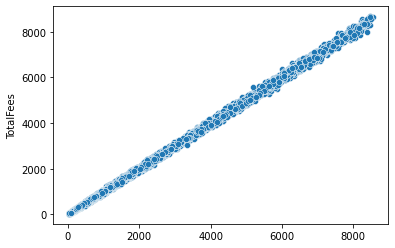

In [9]:
TotalFees_proxy=df['MonthlyBill']*df['TotalMonthsInContract']
sns.scatterplot(x=TotalFees_proxy,y=df['TotalFees'])
plt.show

Given this outcome, using 'TotalFees_proxy' is likely to be more reliable than using mean or median 

In [10]:
missing_col = ['TotalFees']

for i in missing_col:
 df.loc[df.loc[:,i].isnull(),i]=df['TotalMonthsInContract']*df['MonthlyBill']

In [11]:
df.describe()

,IsRetired,TotalMonthsInContract,MonthlyBill,TotalFees,MonthlySpend
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304,64.813767
std,0.368612,24.559481,30.090047,2266.794470,30.261963
min,0.000000,0.000000,18.250000,0.000000,6.780000
25%,0.000000,9.000000,35.500000,398.550000,36.020000
50%,0.000000,29.000000,70.350000,1394.550000,70.900000
75%,0.000000,55.000000,89.850000,3786.600000,89.925000
max,1.000000,72.000000,118.750000,8684.800000,124.930000


Observation : values for 'MonthlyBill' and 'MonthlySpend' are very similar.  Requires further investigation (likely highly correlated, and therefore potentially exclude one of them)

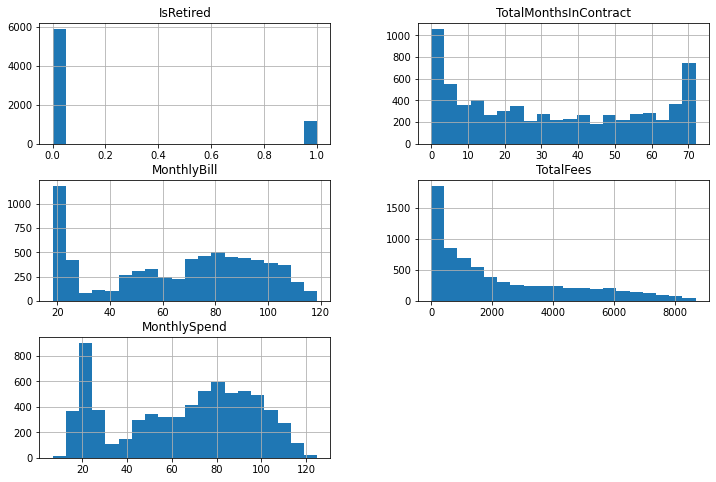

In [12]:
df.hist(figsize=(12,8),bins=20)
plt.show()

Observation : 'TotalFees' looks potentially skewed, and could be addressed through transformation

**Identify Target**

Data Dictionary defines column that indicates if a customer has churned or not  


> '**Retention**' : Has the customer stayed with the company or left.



In [13]:
df["Retention"].value_counts()

Yes    5174
No     1869
Name: Retention, dtype: int64

However, there is another column that appears to have very similar (but not identical) values :


> '**RetentionCheck**' : Column filled by the customer service department.

In [14]:
pd.crosstab(df['Retention'],df["RetentionCheck"])

RetentionCheck,No,Yes
Retention,,
No,1778,91
Yes,261,4913


There are 352 instances where  'Retention' is potentially ambiguous, and may impact the quality of the model. Therefore, I will drop these instances

In [15]:
#drop rows where Retention and RetentionCheck do not agree
df.drop(df[df['Retention']!=df['RetentionCheck']].index, axis=0, inplace=True)

In [16]:
pd.crosstab(df['Retention'],df["RetentionCheck"])

RetentionCheck,No,Yes
Retention,,
No,1778,0
Yes,0,4913


As we are trying to predict ***churn*** rather than ***retention***, we need to set the positive class of the Target variable to 1 - i.e. Retention='No' should be Churn=1

In [17]:
df.loc[df[df['Retention']=='No'].index,'Churn']=1
df.loc[df[df['Retention']=='Yes'].index,'Churn']=0

Drop 'Retention' &'RetentionCheck' as they are no longer needed

In [18]:
df.drop(df[['Retention','RetentionCheck']], axis=1, inplace=True)

In [19]:
df['Churn'].value_counts()

0.0    4913
1.0    1778
Name: Churn, dtype: int64

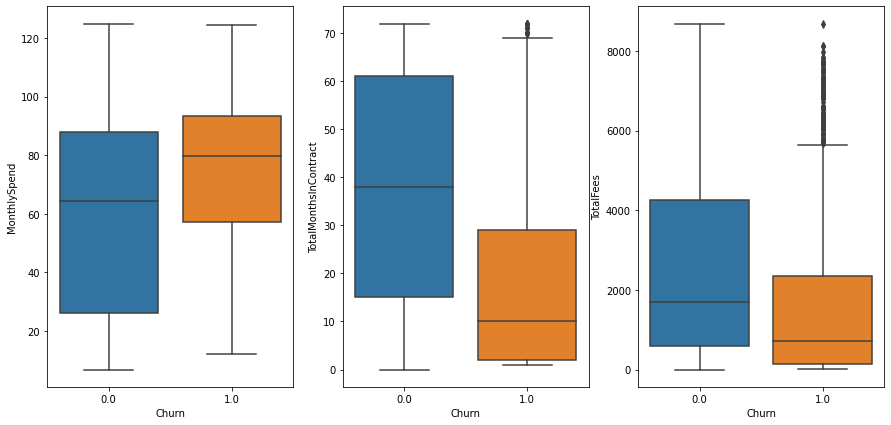

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 7))
sns.boxplot(x=df['Churn'], y=df['MonthlySpend'], ax=ax[0])
sns.boxplot(x=df['Churn'], y=df['TotalMonthsInContract'], ax=ax[1])
sns.boxplot(x=df['Churn'], y=df['TotalFees'], ax=ax[2])

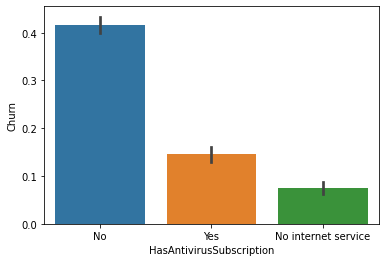

In [21]:
sns.barplot(x=df['HasAntivirusSubscription'], y=df['Churn'])

Observation : 'TotalFees' appears to have outliers that  could impact model performance

In [77]:
df_plot = df.groupby('HasAntivirusSubscription').Churn.mean().reset_index()

In [80]:
df_plot.barplot(x='HasAntivirusSubscription', y='Churn')

AttributeError: ignored

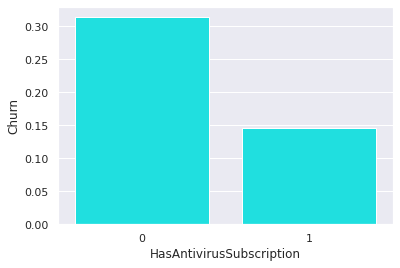

In [82]:
sns.set()
sns.barplot(data = df_plot
            ,x = 'HasAntivirusSubscription'
            ,y = 'Churn'
            ,color = 'cyan' 
            ,ci = None
            )



---



---


### **<u>Data Preprocessing</u>**

Products that are add-on packages for Internet ('HasAntivirusSubscription', 'HasCloudBackUp', 'HasInsurance', 'HasHelpdeskPrivileges', 'HasTVPackage', 'HasMoviePackage') are all set to 'No internet service' where the customer has no internet (ConnectionType='No').\
As the customer does not have these services, this can be set to 'No'.\
(n.b. if we were to OneHot Encode thes columns, they would each return an (identical) 'No internet service' colummn, which would be identical to the Onehot encoded ConnectionType='No', so we are not losing any information.


In [22]:
no_internet_columns=['HasAntivirusSubscription','HasCloudBackUp','HasInsurance','HasHelpdeskPrivileges','HasTVPackage','HasMoviePackage']

In [23]:
for col in no_internet_columns:
  df[col]=df[col].replace({'No internet service':'No'})

Encode 'Yes'/'No' binary features as 1 and 0

In [24]:
yes_no_columns=['IsMarried','HasChildren','HasPhone','HasAntivirusSubscription','HasCloudBackUp','HasInsurance','HasHelpdeskPrivileges','HasTVPackage','HasMoviePackage','OnlineStatements']

In [25]:
for col in yes_no_columns:
  df[col]=df[col].replace({'Yes':1, 'No':0})

'Gender' is also a binary feature and should be encoded 1 and 0

In [26]:
df['Gender']=df['Gender'].replace({'Female':1, 'Male':0})

Feature 'PayTerm' has relative rank, and therefore should be encoded as ordinal

In [27]:
def ordinal_encoder(data,feature,feature_rank):
    
    ordinal_dict = {}
    
    for i, feature_value in enumerate(feature_rank):
        ordinal_dict[feature_value]=i+1
    
    data[feature] = data[feature].map(lambda x: ordinal_dict[x])
    
    return data

In [28]:
df = ordinal_encoder(df,'PayTerm',['Month-to-month','One year','Two year'])

Onehot Encode Categorical Features

In [29]:
#df = df_ordinal_processed
categorical_columns = ['ConnectionType','PreferredPaymentType']
for col in categorical_columns:
    #first replace non alphanumeric with an underscore, to make encoded feature names a bit cleaner
    df[col].replace(to_replace="[^0-9a-zA-Z]+",value="_",regex=True, inplace=True)
    col_ohe = pd.get_dummies(df[col], prefix=col)
    df = pd.concat((df, col_ohe), axis=1).drop(col, axis=1)




---



---


### **<u>Feature Selection and Engineering</u>**

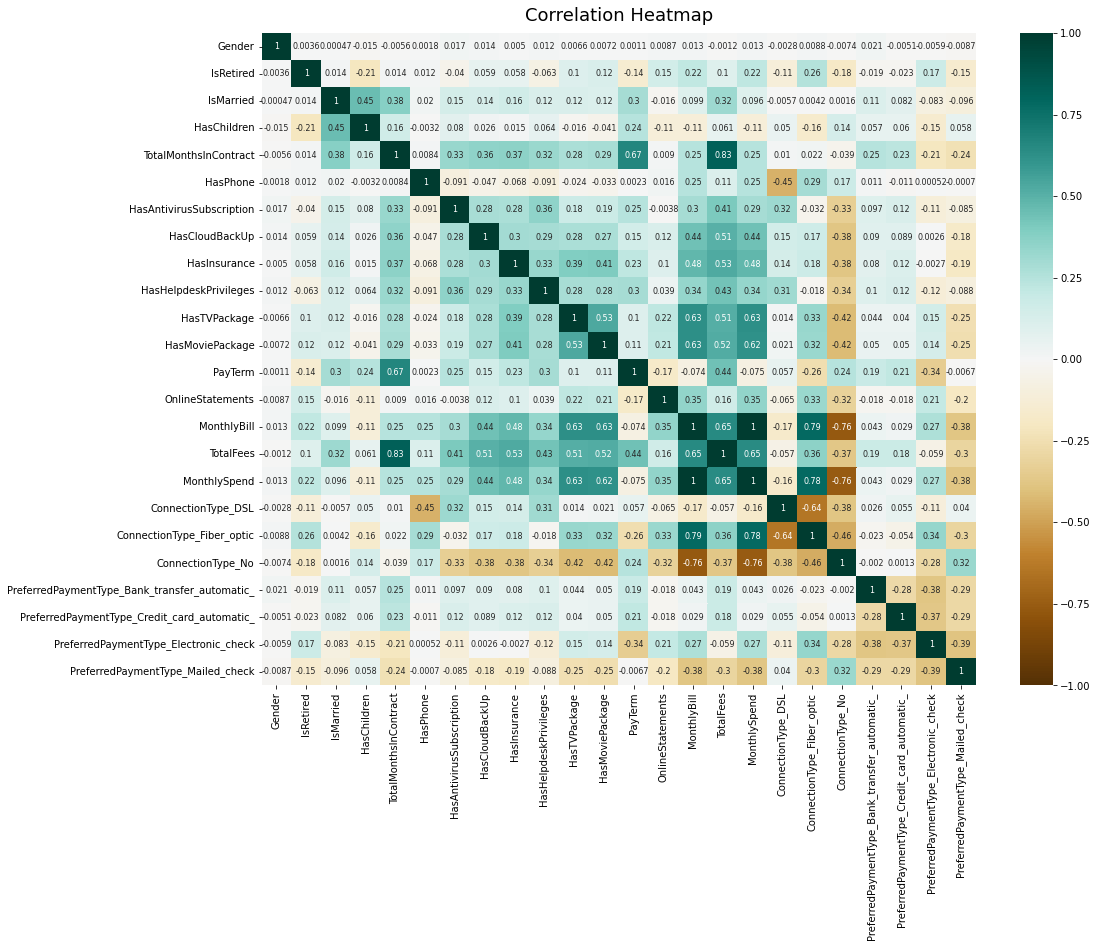

In [30]:
features = df.drop('Churn', axis=1)
corr = features.corr()

plt.figure(figsize=(16, 12))
heatmap = sns.heatmap(features.corr(), vmin=-1, vmax=1, annot=True, annot_kws={"size":8}, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

'MonthlyBill' and 'MonthlySpend' have correlation of 1.    
*Note - 'MonthlySpend' does not appear in the Data Dictionary, so have no information with which to decide how to treat it, so must investigate.*

<function matplotlib.pyplot.show>

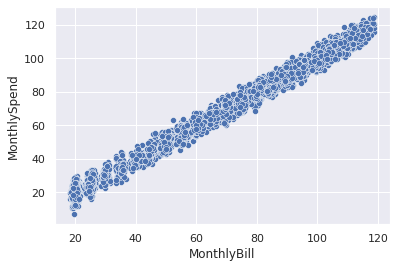

In [31]:
sns.set_theme()
sns.scatterplot(data=df,x='MonthlyBill',y='MonthlySpend')
plt.show

Hypothesis : 'MonthlyBill' is the billed amount, whereas 'MonthlySpend' is what the customer actually pays.  Any difference between the two is over/under spend??
Create a new feature, the difference between spend an billed amount

In [32]:
df['BillVsSpendDiff']=df['MonthlySpend']-df['MonthlyBill']

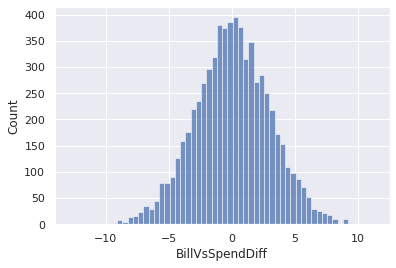

In [33]:
sns.histplot(df['BillVsSpendDiff'])

Now we only need to keep one of 'MonthlyBill' and 'MonthlySpend', so will drop 'MonthlySpend'

In [34]:
df.drop('MonthlySpend',axis=1, inplace=True)

# Split the dataset into Train and Test

In [35]:
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=19)

In [36]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

rus = RandomUnderSampler()
X_train_resampled, y_train_resampled = rus.fit_sample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Initial Models using Default Parameters

Will try:  


*   Logistic Regression
*   Random Forest
*   K Nearest Neigbor






In [42]:
logreg = LogisticRegression()
logreg.fit(X_train_resampled, y_train_resampled)
# Predict the test set labels
y_pred_logreg=logreg.predict(X_test)
# Predict the test set probabilites
y_probs_logreg=logreg.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_logreg))

auc_logreg=roc_auc_score(y_test, y_probs_logreg)
accuracy_logreg=accuracy_score(y_test,y_pred_logreg)
print('\n')
print("ROC AUC Score: %f" % (auc_logreg))
print("Accuracy: %f" %  (accuracy_logreg))
print('\n')
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred_logreg)))

              precision    recall  f1-score   support

         0.0       0.92      0.73      0.81      1491
         1.0       0.50      0.81      0.62       517

    accuracy                           0.75      2008
   macro avg       0.71      0.77      0.72      2008
weighted avg       0.81      0.75      0.76      2008



ROC AUC Score: 0.844989
Accuracy: 0.746514


Confusion Matrix : 
[[1082  409]
 [ 100  417]]


Random Forest on Resampled Data

In [46]:
rf = RandomForestClassifier()
rf.fit(X_train_resampled, y_train_resampled)
# Predict the test set labels
y_pred_rf=rf.predict(X_test)
# Predict the test set probabilites
y_probs_rf=rf.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_rf))

auc_rf=roc_auc_score(y_test, y_probs_rf)
accuracy_rf=accuracy_score(y_test,y_pred_rf)
print('\n')
print("ROC AUC Score: %f" % (auc_rf))
print("Accuracy: %f" %  (accuracy_rf))
print('\n')
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred_rf)))

              precision    recall  f1-score   support

         0.0       0.91      0.73      0.81      1491
         1.0       0.50      0.79      0.61       517

    accuracy                           0.74      2008
   macro avg       0.71      0.76      0.71      2008
weighted avg       0.80      0.74      0.76      2008



ROC AUC Score: 0.834812
Accuracy: 0.744522


Confusion Matrix : 
[[1088  403]
 [ 110  407]]


Random Forest on Original (non-Resampled) Data, but use `class_weight="balanced" `instead

In [47]:
rf_bal = RandomForestClassifier(class_weight="balanced")
rf_bal.fit(X_train, y_train)
# Predict the test set labels
y_pred_rf_bal=rf_bal.predict(X_test)
# Predict the test set probabilites
y_probs_rf_bal=rf_bal.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_rf_bal))

auc_rf_bal=roc_auc_score(y_test, y_probs_rf_bal)
accuracy_rf_bal=accuracy_score(y_test,y_pred_rf_bal)
print('\n')
print("ROC AUC Score: %f" % (auc_rf_bal))
print("Accuracy: %f" %  (accuracy_rf_bal))
print('\n')
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred_rf_bal)))

              precision    recall  f1-score   support

         0.0       0.83      0.91      0.87      1491
         1.0       0.64      0.46      0.53       517

    accuracy                           0.80      2008
   macro avg       0.74      0.68      0.70      2008
weighted avg       0.78      0.80      0.78      2008



ROC AUC Score: 0.832395
Accuracy: 0.795319


Confusion Matrix : 
[[1361  130]
 [ 281  236]]


Random Forest using all data with class_weight="balanced" results in slightly lower ROC_AUC_Score, but negatively impacts recall

In [43]:
knn = KNeighborsClassifier()
knn.fit(X_train_resampled, y_train_resampled)
# Predict the test set labels
y_pred_knn=knn.predict(X_test)
# Predict the test set probabilites
y_probs_knn=knn.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_knn))

auc_knn=roc_auc_score(y_test, y_probs_knn)
accuracy_knn=accuracy_score(y_test,y_pred_knn)
print('\n')
print("ROC AUC Score: %f" % (auc_knn))
print("Accuracy: %f" %  (accuracy_knn))
print('\n')
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred_knn)))

              precision    recall  f1-score   support

         0.0       0.90      0.67      0.77      1491
         1.0       0.45      0.78      0.57       517

    accuracy                           0.70      2008
   macro avg       0.67      0.72      0.67      2008
weighted avg       0.78      0.70      0.72      2008



ROC AUC Score: 0.786581
Accuracy: 0.699203


Confusion Matrix : 
[[1002  489]
 [ 115  402]]


N.B. repeated use of same code for each model. Would be better if I wrote a function to do this (still to do...)

Generate Plot of ROC curve

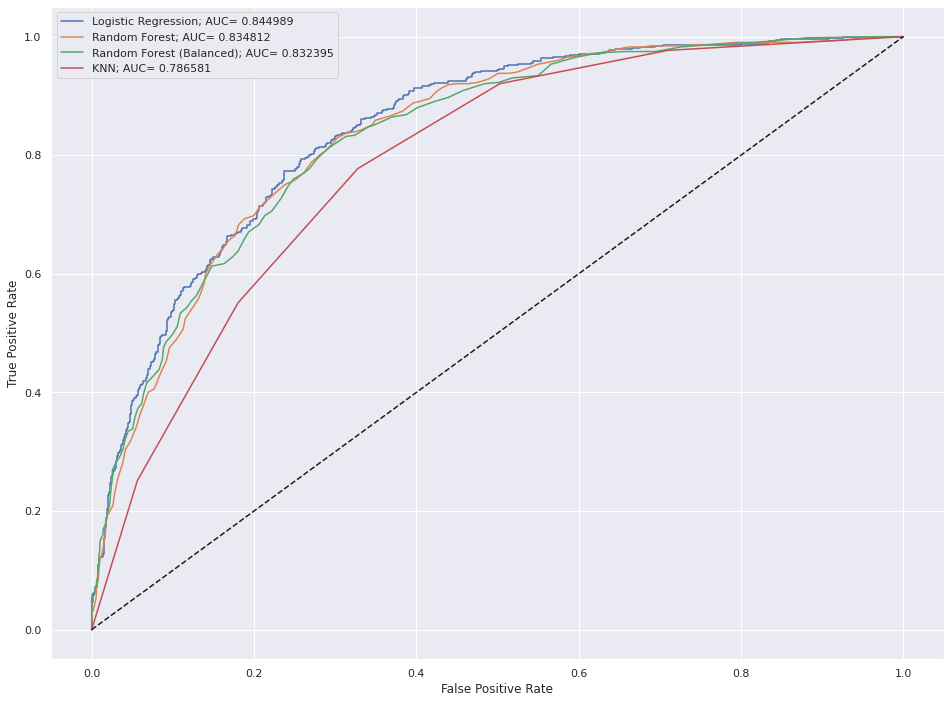

In [48]:
logreg_fpr, logreg_tpr, logreg_thresholds = roc_curve(y_test, y_probs_logreg)
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, y_probs_rf)
rf_bal_fpr, rf_bal_tpr, rf_bal_thresholds = roc_curve(y_test, y_probs_rf_bal)
knn_fpr, knn_tpr, knn_thresholds = roc_curve(y_test, y_probs_knn)

plt.figure(figsize=(16,12))
plt.plot(logreg_fpr, logreg_tpr, label="Logistic Regression; AUC= %f" % (auc_logreg))
plt.plot(rf_fpr, rf_tpr, label="Random Forest; AUC= %f" % (auc_rf))
plt.plot(rf_bal_fpr, rf_bal_tpr, label="Random Forest (Balanced); AUC= %f" % (auc_rf_bal))
plt.plot(knn_fpr, knn_tpr, label="KNN; AUC= %f" % (auc_knn))

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0, 1], [0, 1], "k--")
plt.legend()
plt.show()


# **Tune Hyperparameters using GridSearch and Cross Validation**

Note: decided that based on information available to use `scoring='roc_auc'  `
AUC as it is a function of sensitivity and specificity, the curve is insensitive to disparities in the class proportions.  
  
  If more information was available about (a) the cost of losing a customer who churns, and (b) the cost to retain a customer at risk, then 'Recall' may be a 
more appropriate metric


In [51]:
%%time
param_grid = {'penalty': ['l1', 'l2'],
              'C':[0.001,.009,0.01,.09,1,5,10,25]}

logreg_grid = GridSearchCV(logreg, param_grid, cv=5, verbose=0, scoring='roc_auc', n_jobs=-1)
logreg_grid.fit(X_train_resampled,y_train_resampled)
# Extract best hyperparameters from 'logreg_grid'
best_hyperparams_logreg = logreg_grid.best_params_
print('Best hyerparameters:\n', best_hyperparams_logreg)
# Extract the best model from 'logreg_grid'
best_model_logreg = logreg_grid.best_estimator_
# Predict the test set labels
y_pred_logreg_grid=best_model_logreg.predict(X_test)
# Predict the test set probabilites
y_probs_logreg_grid=best_model_logreg.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_logreg_grid))

auc_logreg_grid=roc_auc_score(y_test, y_probs_logreg_grid)
accuracy_logreg_grid=accuracy_score(y_test,y_pred_logreg_grid)
print('\n')
print("ROC AUC Score: %f" % (auc_logreg_grid))
print("Accuracy: %f" %  (accuracy_logreg_grid))
print('\n')
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred_logreg_grid)))
print('\n')

Best hyerparameters:
 {'C': 10, 'penalty': 'l2'}
              precision    recall  f1-score   support

         0.0       0.92      0.73      0.81      1491
         1.0       0.51      0.81      0.62       517

    accuracy                           0.75      2008
   macro avg       0.71      0.77      0.72      2008
weighted avg       0.81      0.75      0.76      2008



ROC AUC Score: 0.845150
Accuracy: 0.747012


Confusion Matrix : 
[[1081  410]
 [  98  419]]


CPU times: user 219 ms, sys: 73 ms, total: 292 ms
Wall time: 1.29 s


In [50]:
%%time
param_grid = {'max_depth': [3, 5, 6, 7, 8],
              'max_features': [6,7,8,9,10],  
              'min_samples_split': [5, 6, 7, 8]}

rf_grid = GridSearchCV(rf, param_grid, cv=5, verbose=0, scoring='roc_auc', n_jobs=-1)
rf_grid.fit(X_train_resampled,y_train_resampled)
# Extract best hyperparameters from 'rf_grid'
best_hyperparams_rf = rf_grid.best_params_
print('Best hyerparameters:\n', best_hyperparams_rf)
# Extract the best model from 'rf_grid'
best_model_rf = rf_grid.best_estimator_
# Predict the test set labels
y_pred_rf_grid=best_model_rf.predict(X_test)
# Predict the test set probabilites
y_probs_rf_grid=best_model_rf.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_rf_grid))

auc_rf_grid=roc_auc_score(y_test, y_probs_rf_grid)
accuracy_rf_grid=accuracy_score(y_test,y_pred_rf_grid)
print('\n')
print("ROC AUC Score: %f" % (auc_rf_grid))
print("Accuracy: %f" %  (accuracy_rf_grid))
print('\n')
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred_rf_grid)))

Best hyerparameters:
 {'max_depth': 6, 'max_features': 8, 'min_samples_split': 6}
              precision    recall  f1-score   support

         0.0       0.92      0.72      0.81      1491
         1.0       0.50      0.81      0.62       517

    accuracy                           0.75      2008
   macro avg       0.71      0.77      0.71      2008
weighted avg       0.81      0.75      0.76      2008



ROC AUC Score: 0.845631
Accuracy: 0.745518


Confusion Matrix : 
[[1080  411]
 [ 100  417]]
CPU times: user 2.92 s, sys: 254 ms, total: 3.18 s
Wall time: 1min 57s


In [53]:
%%time


param_grid = {'leaf_size': list(range(1,50)),
              'n_neighbors': list(range(1,30)),  
              'p': [1,2]}

knn_grid = GridSearchCV(knn, param_grid, cv=5, verbose=0, scoring='roc_auc', n_jobs=-1)
knn_grid.fit(X_train_resampled,y_train_resampled)
# Extract best hyperparameters from 'rf_grid'
best_hyperparams_knn = knn_grid.best_params_
print('Best hyerparameters:\n', best_hyperparams_knn)
# Extract the best model from 'knn_grid'
best_model_knn = knn_grid.best_estimator_
# Predict the test set labels
y_pred_knn_grid=best_model_knn.predict(X_test)
# Predict the test set probabilites
y_probs_knn_grid=best_model_knn.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_knn_grid))

auc_knn_grid=roc_auc_score(y_test, y_probs_knn_grid)
accuracy_knn_grid=accuracy_score(y_test,y_pred_knn_grid)
print('\n')
print("ROC AUC Score: %f" % (auc_knn_grid))
print("Accuracy: %f" %  (accuracy_knn_grid))
print('\n')
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred_knn_grid)))
print('\n')

Best hyerparameters:
 {'leaf_size': 1, 'n_neighbors': 29, 'p': 1}
              precision    recall  f1-score   support

         0.0       0.91      0.67      0.77      1491
         1.0       0.46      0.82      0.59       517

    accuracy                           0.71      2008
   macro avg       0.69      0.74      0.68      2008
weighted avg       0.80      0.71      0.72      2008



ROC AUC Score: 0.822814
Accuracy: 0.706175


Confusion Matrix : 
[[995 496]
 [ 94 423]]


CPU times: user 38.4 s, sys: 3.3 s, total: 41.7 s
Wall time: 13min 59s


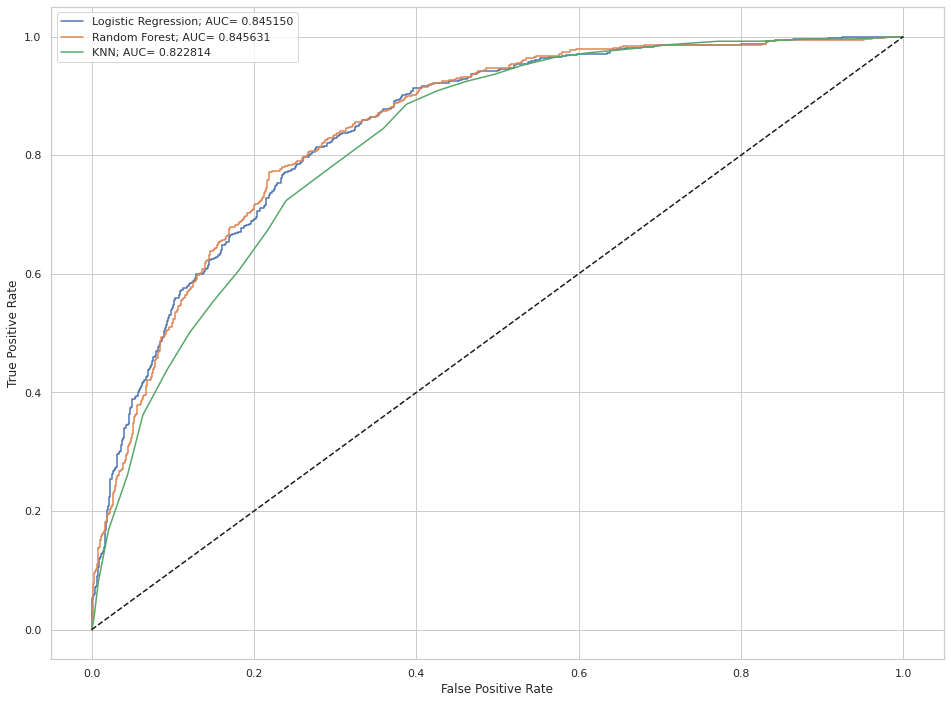

In [75]:
logreg_grid_fpr, logreg_grid_tpr, logreg_grid_thresholds = roc_curve(y_test, y_probs_logreg_grid)
rf_grid_fpr, rf_grid_tpr, rf_grid_thresholds = roc_curve(y_test, y_probs_rf_grid)
knn_grid_fpr, knn_grid_tpr, knn_grid_thresholds = roc_curve(y_test, y_probs_knn_grid)

plt.figure(figsize=(16,12))
plt.plot(logreg_grid_fpr, logreg_grid_tpr, label="Logistic Regression; AUC= %f" % (auc_logreg_grid))
plt.plot(rf_grid_fpr, rf_grid_tpr, label="Random Forest; AUC= %f" % (auc_rf_grid))
plt.plot(knn_grid_fpr, knn_grid_tpr, label="KNN; AUC= %f" % (auc_knn_grid))

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0, 1], [0, 1], "k--")
plt.legend()
plt.show()

In [73]:
importances_best_rf=pd.Series(best_model_rf.feature_importances_, index= X.columns).sort_values(ascending=False)

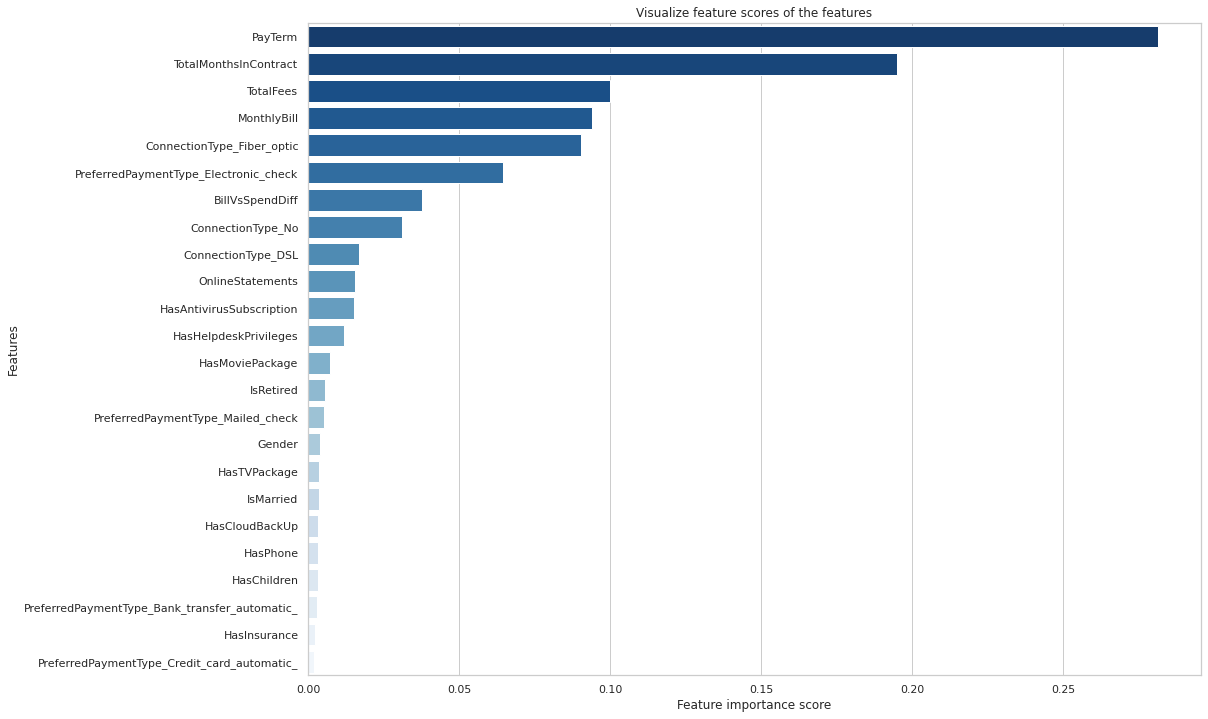

In [74]:
sns.set(style="whitegrid", color_codes=True)

f, ax = plt.subplots(figsize=(16,12))
ax = sns.barplot(x=importances_best_rf, y=importances_best_rf.index ,palette=("Blues_r"))
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(importances_best_rf.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

In [ ]:
#from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_sample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
%%time
param_grid = {'max_depth': [3, 5, 6, 7, 8],
              'max_features': [6,7,8,9,10],  
              'min_samples_split': [5, 6, 7, 8]}

rf_grid_rus = GridSearchCV(rfc, param_grid, cv=5, verbose=1, scoring='recall', n_jobs=-1)
rf_grid_rus.fit(X_train_rus,y_train_rus)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.0min finished


CPU times: user 2.77 s, sys: 205 ms, total: 2.98 s
Wall time: 1min 57s


In [ ]:
# Extract best hyperparameters from 'rf_grid'
best_hyperparams_rus = rf_grid_rus.best_params_
print('Best hyerparameters:\n', best_hyperparams)

Best hyerparameters:
 {'max_depth': 7, 'max_features': 7, 'min_samples_split': 7}


In [ ]:
# Extract the best model from 'rf_grid'
best_model_rus = rf_grid_rus.best_estimator_

In [ ]:
# Predict the test set labels
y_pred_rus=best_model_rus.predict(X_test)

In [ ]:
# Predict the test set labels
y_pred_probs_rus=best_model_rus.predict_proba(X_test)[:,1]

In [ ]:
accuracy_score(y_test,y_pred_rus)

0.7395418326693227

In [ ]:
# classification report
print(classification_report(y_test, y_pred_rus))

              precision    recall  f1-score   support

         0.0       0.92      0.71      0.80      1491
         1.0       0.50      0.82      0.62       517

    accuracy                           0.74      2008
   macro avg       0.71      0.76      0.71      2008
weighted avg       0.81      0.74      0.75      2008



In [ ]:
# Create classifier
clf = LogisticRegression()

# Train model
clf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# Get predicted probabilities
y_score = clf.predict_proba(X_test)[:,1]

In [70]:
dt_fpr, dt_tpr, dt_thresholds = roc_curve(y_test, y_score)
#dt_rus_fpr, dt_rus_tpr, dt_rus_thresholds = roc_curve(y_test, y_pred_probs_rus)
#clf_fpr, clf_tpr, clf_thresholds = roc_curve(y_test, y_score)
xgb_fpr, xgb_tpr, xgb_thresholds = roc_curve(y_test, y_pred_probs_xgb)
plt.plot(dt_fpr, dt_tpr, label='Random Forest (without undersampling')
plt.plot(dt_rus_fpr, dt_rus_tpr, label='Random Forest (with undersampling')
plt.plot(clf_fpr, clf_tpr, label='Logistic Regression')
plt.plot(xgb_fpr, xgb_tpr, label='XGBoost')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0, 1], [0, 1], "k--")
plt.legend()
plt.show()


NameError: ignored

# XGBoost

In [53]:
import xgboost as xgb


xg_cl = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, seed=123)
xg_cl.fit(X_train, y_train)
y_pred_xg=xg_cl.predict(X_test)
accuracy_xg=accuracy_score(y_test,y_pred_xg)
print ("Accuracy XGBoost: %f" % (accuracy_xg))
print(classification_report(y_test, y_pred_xg))

Accuracy XGBoost: 0.792829
              precision    recall  f1-score   support

         0.0       0.82      0.93      0.87      1491
         1.0       0.66      0.41      0.50       517

    accuracy                           0.79      2008
   macro avg       0.74      0.67      0.69      2008
weighted avg       0.78      0.79      0.77      2008



In [57]:

param_grid = {
              'n_estimators': [30, 50, 100],
              'learning_rate': [0.1, 0.2, 0.3, 0.5],
              'gama': [1, 2, 4],
              'max_depth': [5,6,7,8]
              }

xgb_grid = GridSearchCV(xg_cl, param_grid, cv=5, refit=True,verbose=1,scoring='recall', n_jobs=-1)
xgb_grid.fit(X_train,y_train)
xgb_grid = get_best_score(xgb_grid)              

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  3.9min finished


NameError: ignored

In [61]:
# Extract best hyperparameters from 'rf_grid'
best_hyperparams_xgb = xgb_grid.best_params_
print('Best hyerparameters:\n', best_hyperparams_xgb)

Best hyerparameters:
 {'gama': 1, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}


In [62]:
# Extract the best model from 'rf_grid'
best_model_xgb = xgb_grid.best_estimator_

In [63]:
# Predict the test set labels
y_pred_xgb=best_model_xgb.predict(X_test)

In [64]:
# Predict the test set labels
y_pred_probs_xgb=best_model_xgb.predict_proba(X_test)[:,1]

In [65]:
accuracy_score(y_test,y_pred_xgb)

0.7938247011952191

In [66]:
# classification report
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

         0.0       0.83      0.90      0.87      1491
         1.0       0.63      0.49      0.55       517

    accuracy                           0.79      2008
   macro avg       0.73      0.69      0.71      2008
weighted avg       0.78      0.79      0.78      2008



In [54]:
# Create arrays for the features and the target: X, y
#X, y = churn_data.iloc[:,:-1], churn_data.iloc[:,-1]

# Create the DMatrix from X and y: churn_dmatrix
churn_dmatrix = xgb.DMatrix(data=X_train, label=y_train)

# Create the parameter dictionary: params
params = {"objective":"reg:logistic", "max_depth":3}

# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=churn_dmatrix, params=params, 
                  nfold=3, num_boost_round=5, 
                  metrics="error", as_pandas=True, seed=123)

# Print cv_results
print(cv_results)

# Print the accuracy
print(((1-cv_results["test-error-mean"]).iloc[-1]))

   train-error-mean  train-error-std  test-error-mean  test-error-std
0          0.209588         0.006419         0.213752        0.011051
1          0.208627         0.008955         0.211190        0.010479
2          0.205210         0.006017         0.210335        0.014723
3          0.202755         0.008787         0.207773        0.012045
4          0.199872         0.007290         0.207132        0.009019
0.792868


In [55]:
# Perform cross_validation: cv_results
cv_results = xgb.cv(dtrain=churn_dmatrix, params=params, 
                  nfold=3, num_boost_round=5, 
                  metrics="auc", as_pandas=True, seed=123)

# Print cv_results
print(cv_results)

# Print the AUC
print((cv_results["test-auc-mean"]).iloc[-1])

   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.825867       0.006638       0.817795      0.009817
1        0.833040       0.008132       0.820996      0.012754
2        0.838655       0.005987       0.827548      0.014686
3        0.845089       0.005424       0.833428      0.011872
4        0.848104       0.005844       0.835992      0.010996
0.8359923333333333
